In [1]:
import numpy as np
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
from pyecharts.charts import Bar, Line, Timeline, Surface3D, Line3D, Grid
from pyecharts import options as opts
from pyecharts.commons.utils import JsCode
from mpl_toolkits.mplot3d import Axes3D
from scipy.integrate import quad 
from scipy.optimize import root_scalar
import scipy
from scipy.interpolate import griddata

In [2]:
##########
########## define processing time T
########## 
def T(m, T):
    np.random.seed(10)
    t = [np.random.choice(T) for _ in range(m)] # time of finishing the part of each processor 
    return t

In [3]:
##########
########## define processing rate miu
##########
def miu(m, Miu1):
    np.random.seed(10)
    u = [np.random.choice(Miu1) for _ in range(m)] # processing rate of each processor 
    return u

In [4]:
##########
########## define processing time after adding virtual nodes
##########
def T_virtual(virtual_number, T):
    virtual_sum = sum(virtual_number)
    T_vl = np.zeros(virtual_sum)
    a = 0
    for i in range(len(virtual_number)):
        v = virtual_number[i]
        t = T[i]
        T_vl[a:a+v] = t/v
        a += v
    return T_vl    

In [5]:
##########
########## define processing rate after adding virtual nodes
##########
def miu_virtual(virtual_number, Miu):
    virtual_sum = sum(virtual_number)
    Miu_vl = np.zeros(virtual_sum)
    a = 0
    for i in range(len(virtual_number)):
        v = virtual_number[i]
        miu = Miu[i]
        Miu_vl[a:a+v] = miu
        a += v
    return Miu_vl

In [6]:
###########
########### define influx
###########
influx = lambda t: 10*np.sin(t*np.pi/100)
int_influx = lambda t: -(1000/np.pi)*np.cos(t*np.pi/100)
tau_0 = lambda i: (100/np.pi)*np.arccos(1-(np.pi*(i+1)/1000))

In [7]:
# def influx(t):
#     if t <= 20:
#         return 2
#     elif t <= 40:
#         return 10 * np.sin(t * np.pi / 100)
#     elif t <= 60:
#         return 8 + 4 * np.sin(np.pi * (t - 40) / 10)
#     else:
#         return 2 + 2 * np.sin(np.pi * (t - 60) / 10)

In [8]:
# def integrate_influx(tau, fun):
#     result, _ = quad(fun, 0, tau)
#     return result

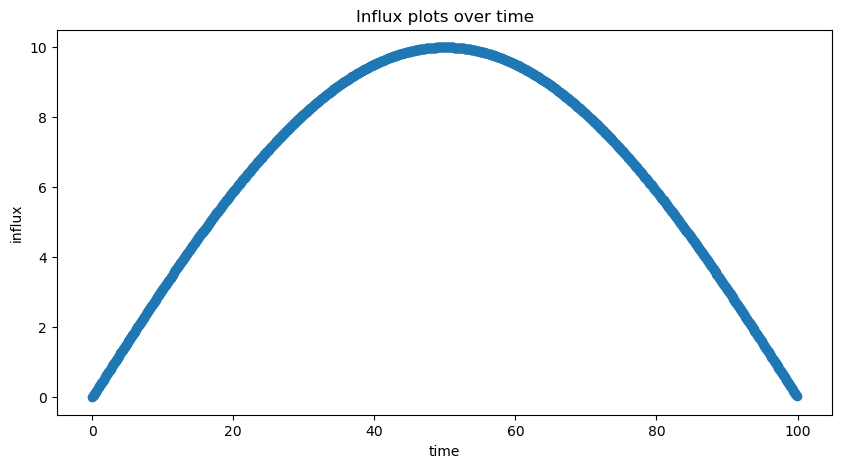

In [8]:
#vectorized_influx = np.vectorize(influx)
###############
############### plot influx
###############
influx_t = np.arange(0, 100, 0.1)
plt.figure(figsize=(10, 5))
plt.plot(influx_t, influx(influx_t),marker='o')
plt.title('Influx plots over time')
plt.xlabel('time')
plt.ylabel('influx')
plt.savefig('influx.png')
plt.show()

In [10]:
# tau_0 = []
# 
# for target in range(12):
#     sol = root_scalar(lambda tau: integrate_influx(tau, vectorized_influx) - target, bracket=[0, 100], method='bisect')
#     if sol.converged:
#         tau_0.append(sol.root)

In [11]:
# tau_0

In [9]:
############
############ formula 8
############
def exact_sol(m, n, T, miu):
    tau = np.zeros((m,n)) # m*n matrix of Eq.8 tau
    a = tau_0(0)
    for i in range(n):
        tau[0,i] = tau_0(i) # initialize the first row
    for i in range(m-1):
        a +=  T[i] # update the sum of finish time 
        tau[i+1,0] = a # update the time of the first part in every processor 
        for j in range(n-1):
            tau[i+1, j+1] = format(max([tau[i,j+1]+T[i], tau[i+1, j]+1/(miu[i])]),'.4f') # follow Eq.8
    return tau

In [10]:
m = 2 # number of processors
n = 636 # number of parts
#n = 12 # number of parts
# T_list = T(m, [1,5])
# miu_list = miu(m, [10])
T_list = [20, 20]
miu_list = [10, 0.5 ]
virtual_number = [20, 20]
sum_vn = sum(virtual_number)

m_virtual = sum_vn

T_v = T_virtual(virtual_number, T_list)
miu_v = miu_virtual(virtual_number, miu_list)
exact_solution = exact_sol(m_virtual, n, T_v, miu_v)
#exact_solution = exact_sol(m, n, T_list, miu_list)

In [14]:
# f_list = []
# for i in range(n-1):
#     a = tau_0(i+1)-tau_0(i)
#     f = 1/a
#     f_list.append(f)

In [11]:
exact_solution

array([[   2.52379354,    3.57011921,    4.37363336, ...,   95.91332451,
          96.78743894,   98.01332577],
       [   3.52379354,    4.5701    ,    5.3736    , ...,   96.9133    ,
          97.7874    ,   99.0133    ],
       [   4.52379354,    5.5701    ,    6.3736    , ...,   97.9133    ,
          98.7874    ,  100.0133    ],
       ...,
       [  39.52379354,   41.5238    ,   43.5238    , ..., 1305.5238    ,
        1307.5238    , 1309.5238    ],
       [  40.52379354,   42.5238    ,   44.5238    , ..., 1306.5238    ,
        1308.5238    , 1310.5238    ],
       [  41.52379354,   43.5238    ,   45.5238    , ..., 1307.5238    ,
        1309.5238    , 1311.5238    ]])

In [12]:
# trace some parts over time and suppliers
index = [1,20,40,80,110,200,370]
supplier = [8, 16, 24, 32]
times = [list(exact_solution[i, index]) for i in supplier]
t2 = Timeline()
for i, time in enumerate(times):
    bar = (
        Bar()
        .add_xaxis(xaxis_data=index)
        .add_yaxis(
            series_name=f"Supplier {i}",
            y_axis=time)
        .set_global_opts(
            title_opts=opts.TitleOpts("Arrival time at Supplier {} of parts".format(i)),
            yaxis_opts=opts.AxisOpts(name="Time", type_='value', min_=min(times), max_=max(times)),
            xaxis_opts=opts.AxisOpts(name="Part Index", type_='category'),
        )
    )

    t2.add(bar, "Supplier {}".format(i))
t2.add_schema(
    play_interval=500,  
    is_auto_play=True, 
    is_loop_play=False 
)
t2.render('bar.html')

'C:\\Users\\DELL\\Advanced Modeling\\bar.html'

In [17]:
# # compare rho (from tau) and rho (from analytical expression)
# for mm in range(100, 110):
#     #mm = 1 # 0 to 199
#     xmm = mm
#     
#     rhoc1_lst = []
#     rhoc2_lst = []
#     tt_lst = []
#     
#     for nn in range(0, 600):
#         tt = exact_solution[mm+1, nn]
#         
#         # from exact time point tau
#         rhoc1 = (exact_solution[mm+1, nn+1] - exact_solution[mm, nn+1])/(exact_solution[mm+1, nn+1] - exact_solution[mm+1, nn])
#         
#         # from analytical PDE solution
#         rhoc2 = influx(tt-xmm)
#         #rhoc2 = miu_list[1]
#         # compare
#         # print(f'tau({mm+1},{nn})', tt, rhoc1, rhoc2, 'error', rhoc1 - rhoc2)
#         rhoc1_lst.append(rhoc1)
#         rhoc2_lst.append(rhoc2)
#         tt_lst.append(tt)
#         
#     plt.figure()
#     plt.title(f"m{mm}")
#     plt.scatter(tt_lst, rhoc1_lst, label="from exact tau")
#     plt.scatter(tt_lst, rhoc2_lst, label="from PDE analytical")
#     plt.legend()
# # plt.show()


In [13]:
############
############ maximum of exact_solution
############
max(exact_solution[-1,:])

1311.5238

In [14]:
############
############ initialize PDE numerical solution
############
delta_t = 0.1 # time step
# MT0 = sum(T_list) # total finishing time
# delta_x = np.array(T_list)/MT0 # space step
MT0 = sum(T_v) # total finishing time
delta_x = np.array(T_v)/MT0 # space step
t_final = 15000 # endpoint of discretion
f0 = []
for i in range(1000):
    f0.append(influx(delta_t*i))

In [15]:
############
############ formula 36
############
def discrete_update(miu, m, tn, deltat,deltax, f0):
    f = np.zeros((m+1, tn+1))
    rho = np.zeros((m, tn+1))
    #rho[0,0] = f0[0]*deltat/deltax[0] # update the first element of rho
    f[0,:len(f0)] = f0 # update the first row of f
    k_list = []
    i_list = []
    for i in range(1, tn+1):
        for j in range(m): 
            rho[j, i] = rho[j, i-1] - (deltat/deltax[j])*(f[j+1,i-1] - f[j, i-1])
        for k in range(1, m+1):
            if miu[k-1] < rho[k-1, i]/MT0:
                k_list.append(k)
                i_list.append(i)
            f[k, i] = min([miu[k-1], rho[k-1, i]/MT0])
            
    return f, rho, k_list, i_list

In [16]:
f_pde, rho_pde, k, i = discrete_update(miu_v, m_virtual, t_final, delta_t, delta_x, f0)

In [17]:
# flux f 3D plots
x_range = np.zeros(m_virtual)
for i in range(m_virtual):
    x_range[i] = sum(delta_x[:i+1])
t_range = np.arange(f_pde.shape[1])/10 
X, T = np.meshgrid(x_range, t_range)
F = f_pde[:len(x_range), :len(t_range)].T

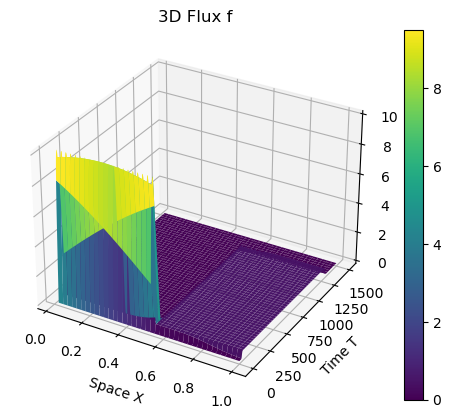

In [18]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X, T, F, cmap='viridis')
fig.colorbar(surf)
ax.set_xlabel('Space X')
ax.set_ylabel('Time T')
ax.set_zlabel('Flux f')
ax.set_title('3D Flux f')
plt.savefig('3 D flux f.png')
plt.show()

In [19]:
data = [[[x, t, float(F[t, x])] for x in range(len(x_range))] for t in range(len(t_range))]
data = [item for sublist in data for item in sublist] 

surface3d = (
    Surface3D()
    .add(
        series_name="Surface",
        data=data,
        shading="color",
        itemstyle_opts=opts.ItemStyleOpts(
            opacity=0.8,
            color=JsCode("new echarts.graphic.LinearGradient(0, 0, 0, 1, [{offset: 0, color: 'green'}, {offset: 1, color: 'blue'}], false)") 
        ),
        xaxis3d_opts=opts.Axis3DOpts(type_="value", name="Space"),
        yaxis3d_opts=opts.Axis3DOpts(type_="value", name="Time"),
        zaxis3d_opts=opts.Axis3DOpts(type_="value", name="Flux f"),
        grid3d_opts=opts.Grid3DOpts(
            rotate_speed=20,
            is_rotate=False
        )
    )
    .set_global_opts(
        visualmap_opts=opts.VisualMapOpts(
            max_=np.max(F),
            min_=np.min(F),
            dimension=2,
            range_color=['#0000ff', '#ff0000']
        )
    )
)

# Render to HTML file
surface3d.render("3D Flux f.html")

'C:\\Users\\DELL\\Advanced Modeling\\3D Flux f.html'

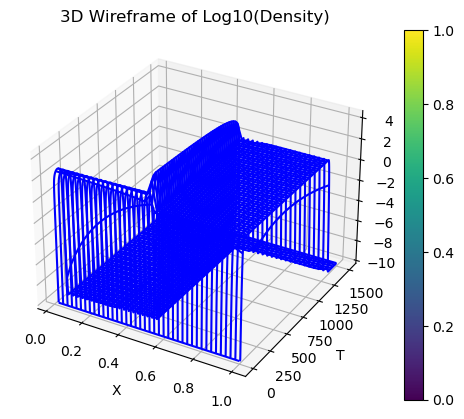

In [20]:
# density rho 3D plots
Rho = np.log10(rho_pde[:len(x_range), :len(t_range)].T+1e-10)
fig_rho = plt.figure()
ax_rho = fig_rho.add_subplot(111, projection='3d')
wireframe = ax_rho.plot_wireframe(X, T, Rho, color='blue')
fig_rho.colorbar(wireframe)
ax_rho.set_title('3D Wireframe of Log10(Density)')
ax_rho.set_xlabel('X')
ax_rho.set_ylabel('T')
ax_rho.set_zlabel('Log10(Rho)')
plt.savefig('Density.png')
plt.show()

In [21]:
data_rho = [[[i, j, float(Rho[j, i])] for i in range(len(x_range))] for j in range(len(t_range))]
data_rho = [item for sublist in data_rho for item in sublist]
surface3d = (
    Surface3D()
    .add(
        series_name="Surface",
        data=data_rho,
        shading="color",
        itemstyle_opts=opts.ItemStyleOpts(
            opacity=0.8, 
            color=JsCode("new echarts.graphic.LinearGradient(0, 0, 0, 1, [{offset: 0, color: 'green'}, {offset: 1, color: 'blue'}], false)")
        ),
        xaxis3d_opts=opts.Axis3DOpts(type_="value", name="Space"),
        yaxis3d_opts=opts.Axis3DOpts(type_="value", name="Time"),
        zaxis3d_opts=opts.Axis3DOpts(type_="value", name="Density log rho"),
        grid3d_opts=opts.Grid3DOpts(
            rotate_speed=20,
            is_rotate=True
        )
    )
    .set_global_opts(
        visualmap_opts=opts.VisualMapOpts(
            max_=np.max(Rho),
            min_=1,
            dimension=2,
            range_color=['#0000ff', '#ff0000']
        )
    )
)

surface3d.render("3D_Log10_Rho.html")

'C:\\Users\\DELL\\Advanced Modeling\\3D_Log10_Rho.html'

In [18]:
###########
########### exact_solution rho and flux according formula 13
###########
def exact_f(tau, m, n):
    f = np.zeros((m, n))
    for row in range(m):
        for col in range(n-1):
            if tau[row, col+1] != tau[row, col]:
                f[row, col] = 1/ (tau[row, col + 1] - tau[row, col])

    return f

In [19]:
f_exact = exact_f(exact_solution, m_virtual, n)

In [20]:
def exact_rho(delta, tau, m, n):
    rho = np.zeros((m, n))
    for i in range(m-1): 
        for j in range(n-1):
            h_i = delta[i]
            rho[i, j] = (tau[i+1, j+1] - tau[i, j+1]) / (h_i * (tau[i+1, j+1] - tau[i+1, j]))

    return rho

In [21]:
rho_exact = exact_rho(delta_x, exact_solution, m_virtual, n)

In [22]:
def compare_f_for_fixed_m(m, n, exactf, pdef,exact_solution, index):
    y_exact_value = exactf[m]
    x_exact_value = exact_solution[m]
    start = np.floor(exact_solution[m, 0]).astype(int)
    end = np.ceil(exact_solution[m, n-1]).astype(int)
    x_pde_value = np.arange(start, end, 0.1) 
    y_pde_value = pdef[m,start*10:end*10]
    plt.figure(figsize=(10, 5))
    plt.scatter(x_exact_value, y_exact_value, label='Exact Solution', color='b', marker='o')
    plt.plot(x_pde_value, y_pde_value, label='PDE Numerical Solution', color='r', linestyle='-')
    plt.legend()
    plt.title(f'Comparison of Exact and Numerical Solutions for m={index}')
    plt.xlabel('time')
    plt.ylabel('values')
    plt.grid(True)  
    #plt.savefig('Comparsion of density.png') ## save figure(hint: change the figure name)
    plt.show()


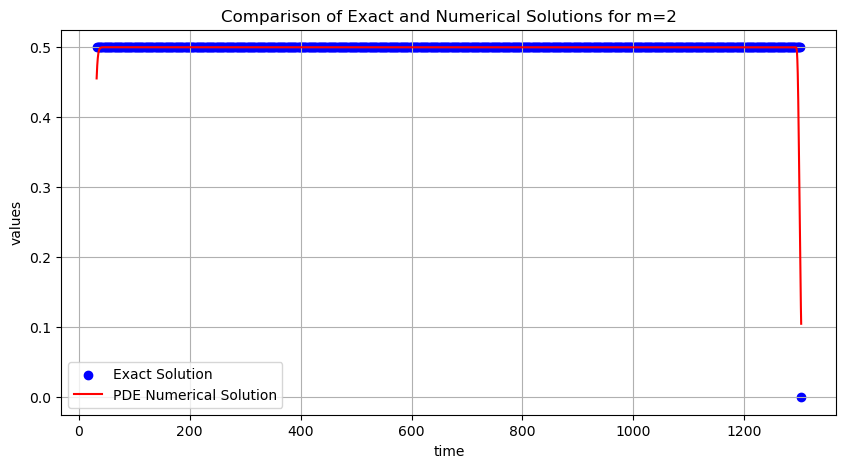

In [23]:
compare_f_for_fixed_m(30,n,f_exact,f_pde,exact_solution, 2)

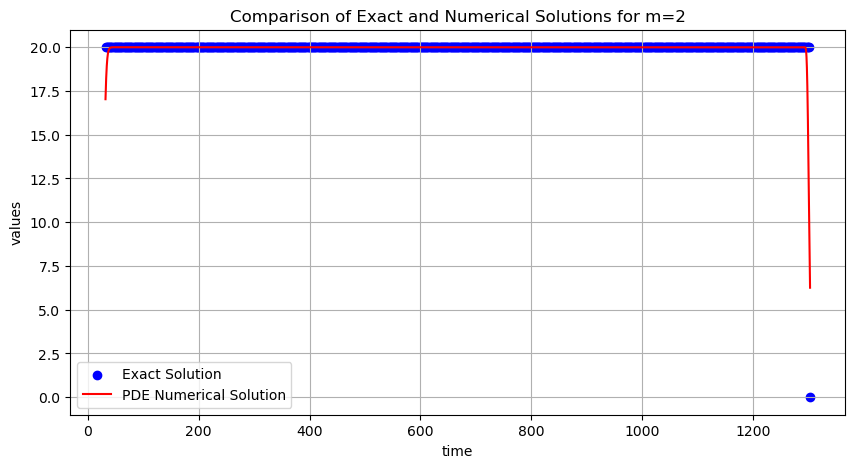

In [24]:
compare_f_for_fixed_m(30,n,rho_exact,rho_pde,exact_solution, 2)

Two suppliers

In [34]:
holding_constant = [12.5, 12.5]
T_list = [20, 20]
virtual_number = [20, 20]
m = 2

In [35]:
def optimization_min_holdcost(miu_list, T_list = T_list, virtual_number = virtual_number, influx = influx, holding_constant = holding_constant):
    sum_vn = sum(virtual_number)
    m_virtual = sum_vn
    
    T_v = T_virtual(virtual_number, T_list)
    miu_v = miu_virtual(virtual_number, miu_list)
    
    delta_t = 0.1 
    MT0 = sum(T_v) # total finishing time
    delta_x = np.array(T_v)/MT0 # space step
    t_final = 15000 # endpoint of discretion
    f0 = []
    for i in range(1000):
        f0.append(influx(delta_t*i))

    f_pde, rho_pde, k, i = discrete_update(miu_v, m_virtual, t_final, delta_t, delta_x, f0)
    
    area = np.zeros(m)
    
    rho_pde_0 = rho_pde[:virtual_number[0], :]
    area[0] = np.sum(rho_pde_0) * delta_x[0] * delta_t
    
    for i in range(1,m):
        rho_pde_area = rho_pde[virtual_number[i-1]:virtual_number[i-1]+virtual_number[i], : ]
        area[i] = np.sum(rho_pde_area) * delta_x[sum(virtual_number[:i])+1] * delta_t
    
    hold_cost = sum(np.multiply(area, holding_constant))
    
    
    return hold_cost

In [36]:
def constraint_summiu(miu):
    return sum(miu) - 15

In [37]:
miu1 = np.arange(3.0, 12.0, 0.2)
C = 15 # sum of miu
len_loop = len(miu1)
miu2 = np.zeros(len_loop)

hold_cost = np.zeros(len_loop)
for i in range(len_loop):
    miu2[i] = C - miu1[i]
    miu = [miu1[i], miu2[i]]
    
    hold_cost[i] = optimization_min_holdcost(miu)

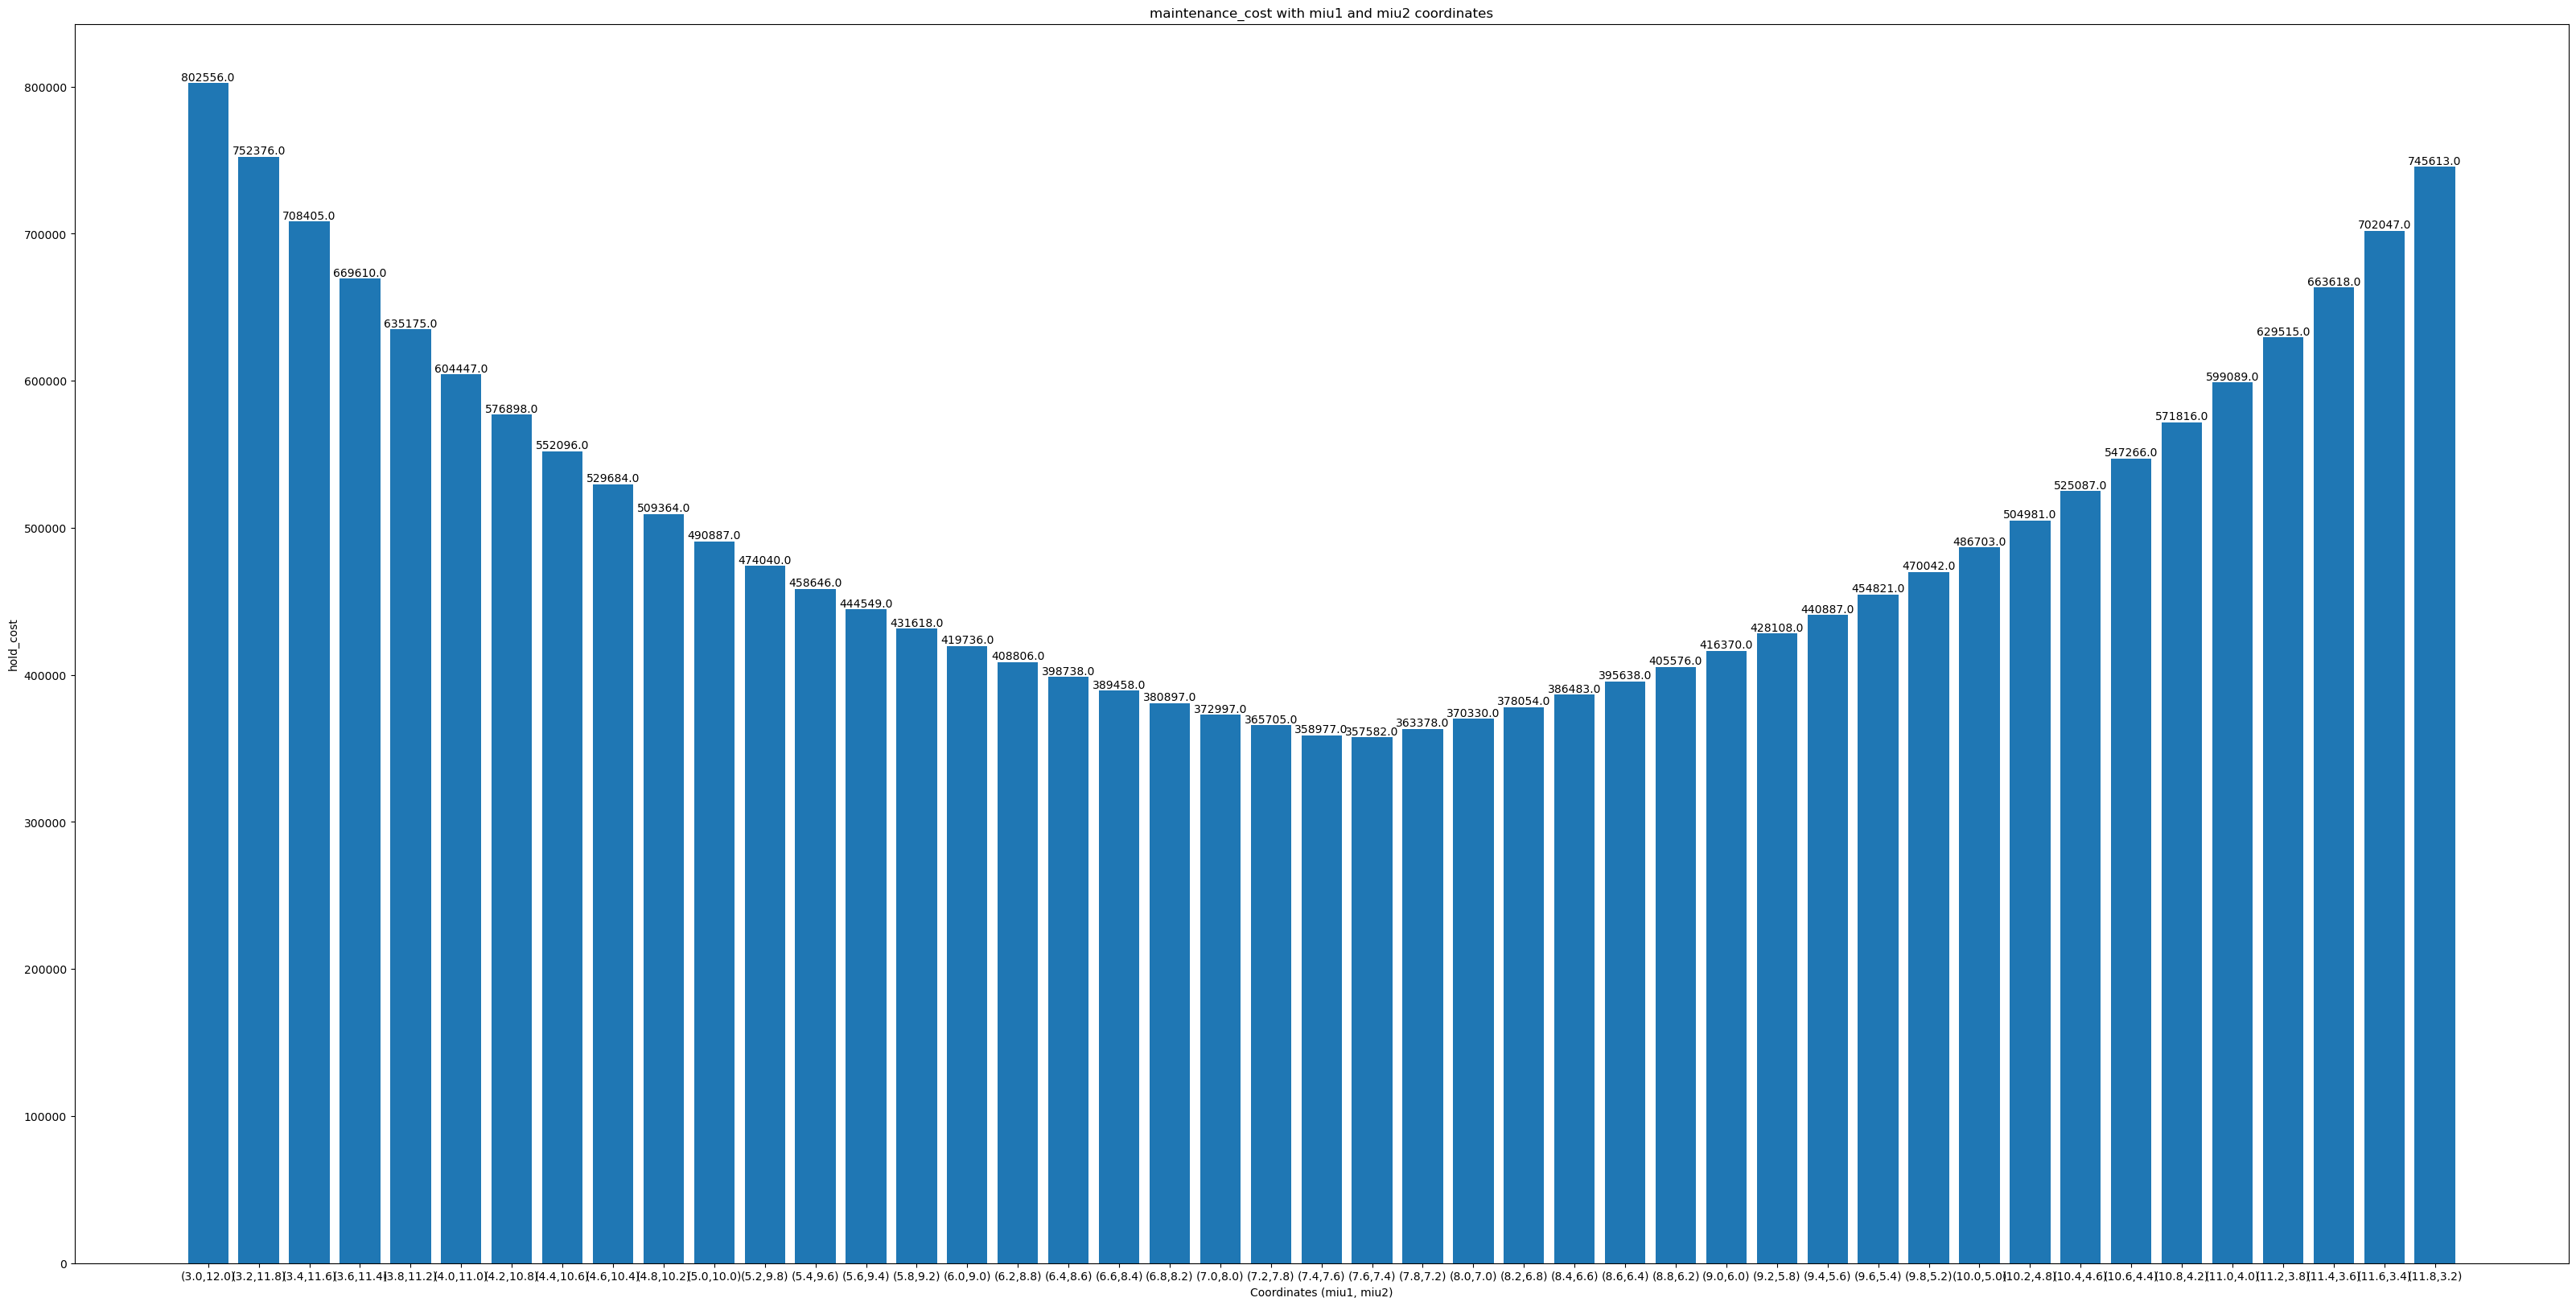

In [38]:
#log_hold = np.log(hold_cost)
data = pd.DataFrame({'miu1': [round(miu_1,2) for miu_1 in miu1], 'miu2': [round(miu_2,2) for miu_2 in miu2], 'hold': hold_cost, 'hold_cost': [round(hold_cost1,0) for hold_cost1 in hold_cost]})
plt.figure(figsize=(40, 20))
bars = plt.bar(range(len(data)), data['hold_cost'], tick_label=[f'({i},{j})' for i, j in zip(data['miu1'], data['miu2'])])

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.1, round(yval, 2), ha='center', va='bottom')

plt.title('maintenance_cost with miu1 and miu2 coordinates')
plt.xlabel('Coordinates (miu1, miu2)')
plt.ylabel('hold_cost')
plt.savefig(f'hold_cost {holding_constant}.png')
plt.show()

In [124]:
miu_init = [7.4, 7.6]
bounds = [(0, None), (0, None)]
constraints = {'type': 'eq', 'fun': constraint_summiu}
res = scipy.optimize.minimize(optimization_min_holdcost, miu_init, method='SLSQP', bounds=bounds, constraints=constraints)
res

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 348315.67851276195
       x: [ 7.500e+00  7.500e+00]
     nit: 12
     jac: [-1.235e+04 -1.233e+04]
    nfev: 45
    njev: 12

In [123]:
optimization_min_holdcost([7.501, 7.499])

355813.7770350266

In [39]:
xaxis = data[['miu1','miu2']].values.tolist()
bar = (
    Bar()
    .add_xaxis(xaxis)
    .add_yaxis("hold_cost", data['hold_cost'].values.tolist())
    .set_global_opts(title_opts=opts.TitleOpts(title="log(hold_cost) with miu1 and miu2 coordinates"),
                     xaxis_opts=opts.AxisOpts(type_="category"),
                     legend_opts=opts.LegendOpts(is_show=True))
)

line_data = []
for i, (x, y) in enumerate(zip(data['miu1'], data['miu2'])):
    line_data.append((f'({x},{y})', data['hold_cost'][i]))

line = (
    Line()
    .add_xaxis([item[0] for item in line_data])
    .add_yaxis("hold_cost", [item[1] for item in line_data])
    .set_series_opts(label_opts=opts.LabelOpts(is_show=False))
)
# 
line.set_global_opts(datazoom_opts=opts.DataZoomOpts(),
                     xaxis_opts=opts.AxisOpts(type_="category", name="miu1, miu2"),
                     yaxis_opts=opts.AxisOpts(name="hold cost"),
                     legend_opts=opts.LegendOpts(is_show=True),
                     title_opts=opts.TitleOpts(title="Hold Cost with Different miu"))
bar.set_global_opts(datazoom_opts=opts.DataZoomOpts())


line.overlap(bar)

line.render(f"hold_cost of 2 suppliers {holding_constant}.html")
# grid_chart = (
#     Grid(init_opts=opts.InitOpts(width="1600px", height="800px"))
#     .add(bar, grid_opts=opts.GridOpts())
#     .add(line, grid_opts=opts.GridOpts())
# )
# 
# # 渲染图表
# grid_chart.render("hold_cost.html")


'C:\\Users\\DELL\\Advanced Modeling\\hold_cost of 2 suppliers [12.5, 12.5].html'

Three suppliers

In [103]:
T_list = [20, 20, 20]
virtual_number = [20, 20, 20]
holding_constant = [8,16,12]
m = 3

In [104]:
def optimization_min_holdcost(miu_list, T_list = T_list, virtual_number = virtual_number, influx = influx, holding_constant = holding_constant):
    sum_vn = sum(virtual_number)
    m_virtual = sum_vn
    
    T_v = T_virtual(virtual_number, T_list)
    miu_v = miu_virtual(virtual_number, miu_list)
    
    delta_t = 0.1 
    MT0 = sum(T_v) # total finishing time
    delta_x = np.array(T_v)/MT0 # space step
    t_final = 15000 # endpoint of discretion
    f0 = []
    for i in range(1000):
        f0.append(influx(delta_t*i))

    f_pde, rho_pde, k, i = discrete_update(miu_v, m_virtual, t_final, delta_t, delta_x, f0)
    
    area = np.zeros(m)
    
    rho_pde_0 = rho_pde[:virtual_number[0], :]
    area[0] = np.sum(rho_pde_0) * delta_x[0] * delta_t
    
    for i in range(1,m):
        rho_pde_area = rho_pde[virtual_number[i-1]:virtual_number[i-1]+virtual_number[i], : ]
        area[i] = np.sum(rho_pde_area) * delta_x[sum(virtual_number[:i])+1] * delta_t
    
    hold_cost = sum(np.multiply(area, holding_constant))
    
    
    return hold_cost

In [105]:
def constraint_summiu(miu):
    return sum(miu) - 24

In [106]:
miu11 = np.arange(6.0, 10.0, 0.2)
miu22 = np.arange(6.0, 10.0, 0.2)
C = 24
len_loop1 = len(miu11)
len_loop2 = len(miu22)
miu33 = np.zeros(len_loop1 * len_loop2)
miu11_final = np.zeros(len_loop1 * len_loop2)
miu22_final = np.zeros(len_loop1 * len_loop2)
hold_cost = np.zeros(len_loop1 * len_loop2)
for i in range(len_loop1):
    for j in range(len_loop2):
        miu33[len_loop1*i+j] = C - miu11[i] - miu22[j]
        miu = [miu11[i], miu22[j], miu33[len_loop1*i+j]]
        miu11_final[len_loop1*i+j] = miu11[i]
        miu22_final[len_loop1*i+j] = miu22[j]
        
        hold_cost[len_loop1*i+j] = optimization_min_holdcost(miu)

In [107]:
data = pd.DataFrame({'miu1': [round(miu_1,2) for miu_1 in miu11_final], 'miu2': [round(miu_2,2) for miu_2 in miu22_final], 'miu3': [round(miu_3,2) for miu_3 in miu33], 'hold': hold_cost, 'hold_cost': [round(hold_cost1,0) for hold_cost1 in hold_cost]})
xi = np.linspace(data['miu1'].min(), data['miu1'].max(), 100)
yi = np.linspace(data['miu2'].min(), data['miu2'].max(), 100)
xi, yi = np.meshgrid(xi, yi)
zi = griddata((data['miu1'], data['miu2']), data['hold_cost'], (xi, yi), method='cubic')

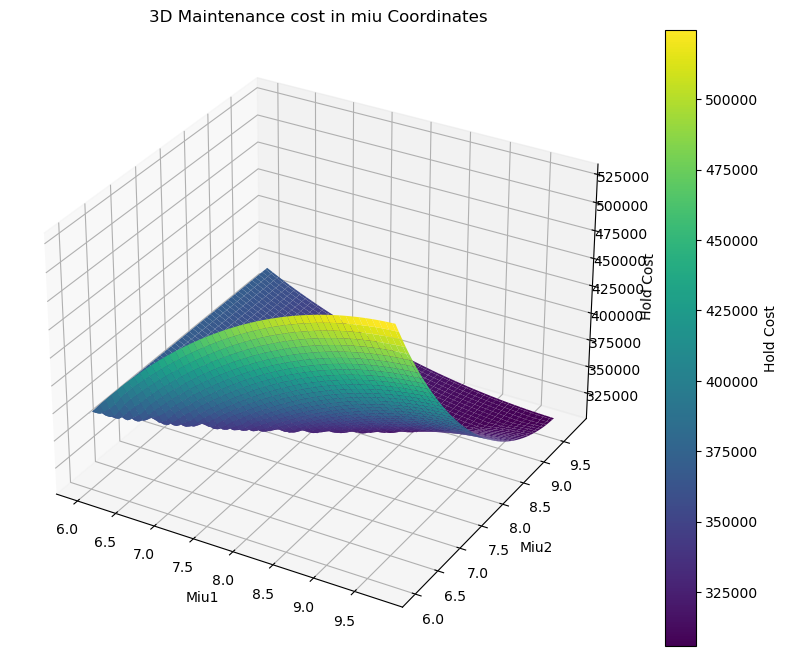

In [108]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
surface = ax.plot_surface(xi, yi, zi, cmap='viridis')

cbar = fig.colorbar(surface)
cbar.set_label('Hold Cost')

ax.set_xlabel('Miu1')
ax.set_ylabel('Miu2')
ax.set_zlabel('Hold Cost')

plt.title('3D Maintenance cost in miu Coordinates')
plt.savefig(f'hold_cost {holding_constant}.png')
plt.show()

In [109]:
data = [[x, y, z] for x, y, z in zip(xi.flatten(), yi.flatten(), zi.flatten())]
surface3d = (
    Surface3D()
    .add(
        series_name="Surface",
        data=data,
        shading="color",
        itemstyle_opts=opts.ItemStyleOpts(
            opacity=0.8, 
            color=JsCode("new echarts.graphic.LinearGradient(0, 0, 0, 1, [{offset: 0, color: 'green'}, {offset: 1, color: 'blue'}], false)")
        ),
        xaxis3d_opts=opts.Axis3DOpts(type_="value", name="miu1", min_=min(xi.flatten()), max_=max(xi.flatten())),
        yaxis3d_opts=opts.Axis3DOpts(type_="value", name="miu2", min_=min(yi.flatten()), max_=max(yi.flatten())),
        zaxis3d_opts=opts.Axis3DOpts(type_="value", name="Maintenance cost"),
        grid3d_opts=opts.Grid3DOpts(
            rotate_speed=20,
            is_rotate=True
        )
    )
    .set_global_opts(
        visualmap_opts=opts.VisualMapOpts(
            max_=max(zi.flatten()),
            min_=min(zi.flatten()),
            dimension=2,
            range_color=['#0000ff', '#ff0000']
        )
    )
)

surface3d.render(f"3D Maintenance cost in miu Coordinates {holding_constant}.html")

'C:\\Users\\DELL\\Advanced Modeling\\3D Maintenance cost in miu Coordinates [8, 16, 12].html'

In [113]:
miu_init = [9.8, 9.6, 4.4]
bounds = [(0, None), (0, None),(0, None)]
constraints = {'type': 'eq', 'fun': constraint_summiu}
res = scipy.optimize.minimize(optimization_min_holdcost, miu_init, method='SLSQP', bounds=bounds, constraints=constraints)
res

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 305577.2394089854
       x: [ 1.043e+01  1.043e+01  3.141e+00]
     nit: 3
     jac: [ 0.000e+00  0.000e+00  0.000e+00]
    nfev: 19
    njev: 3

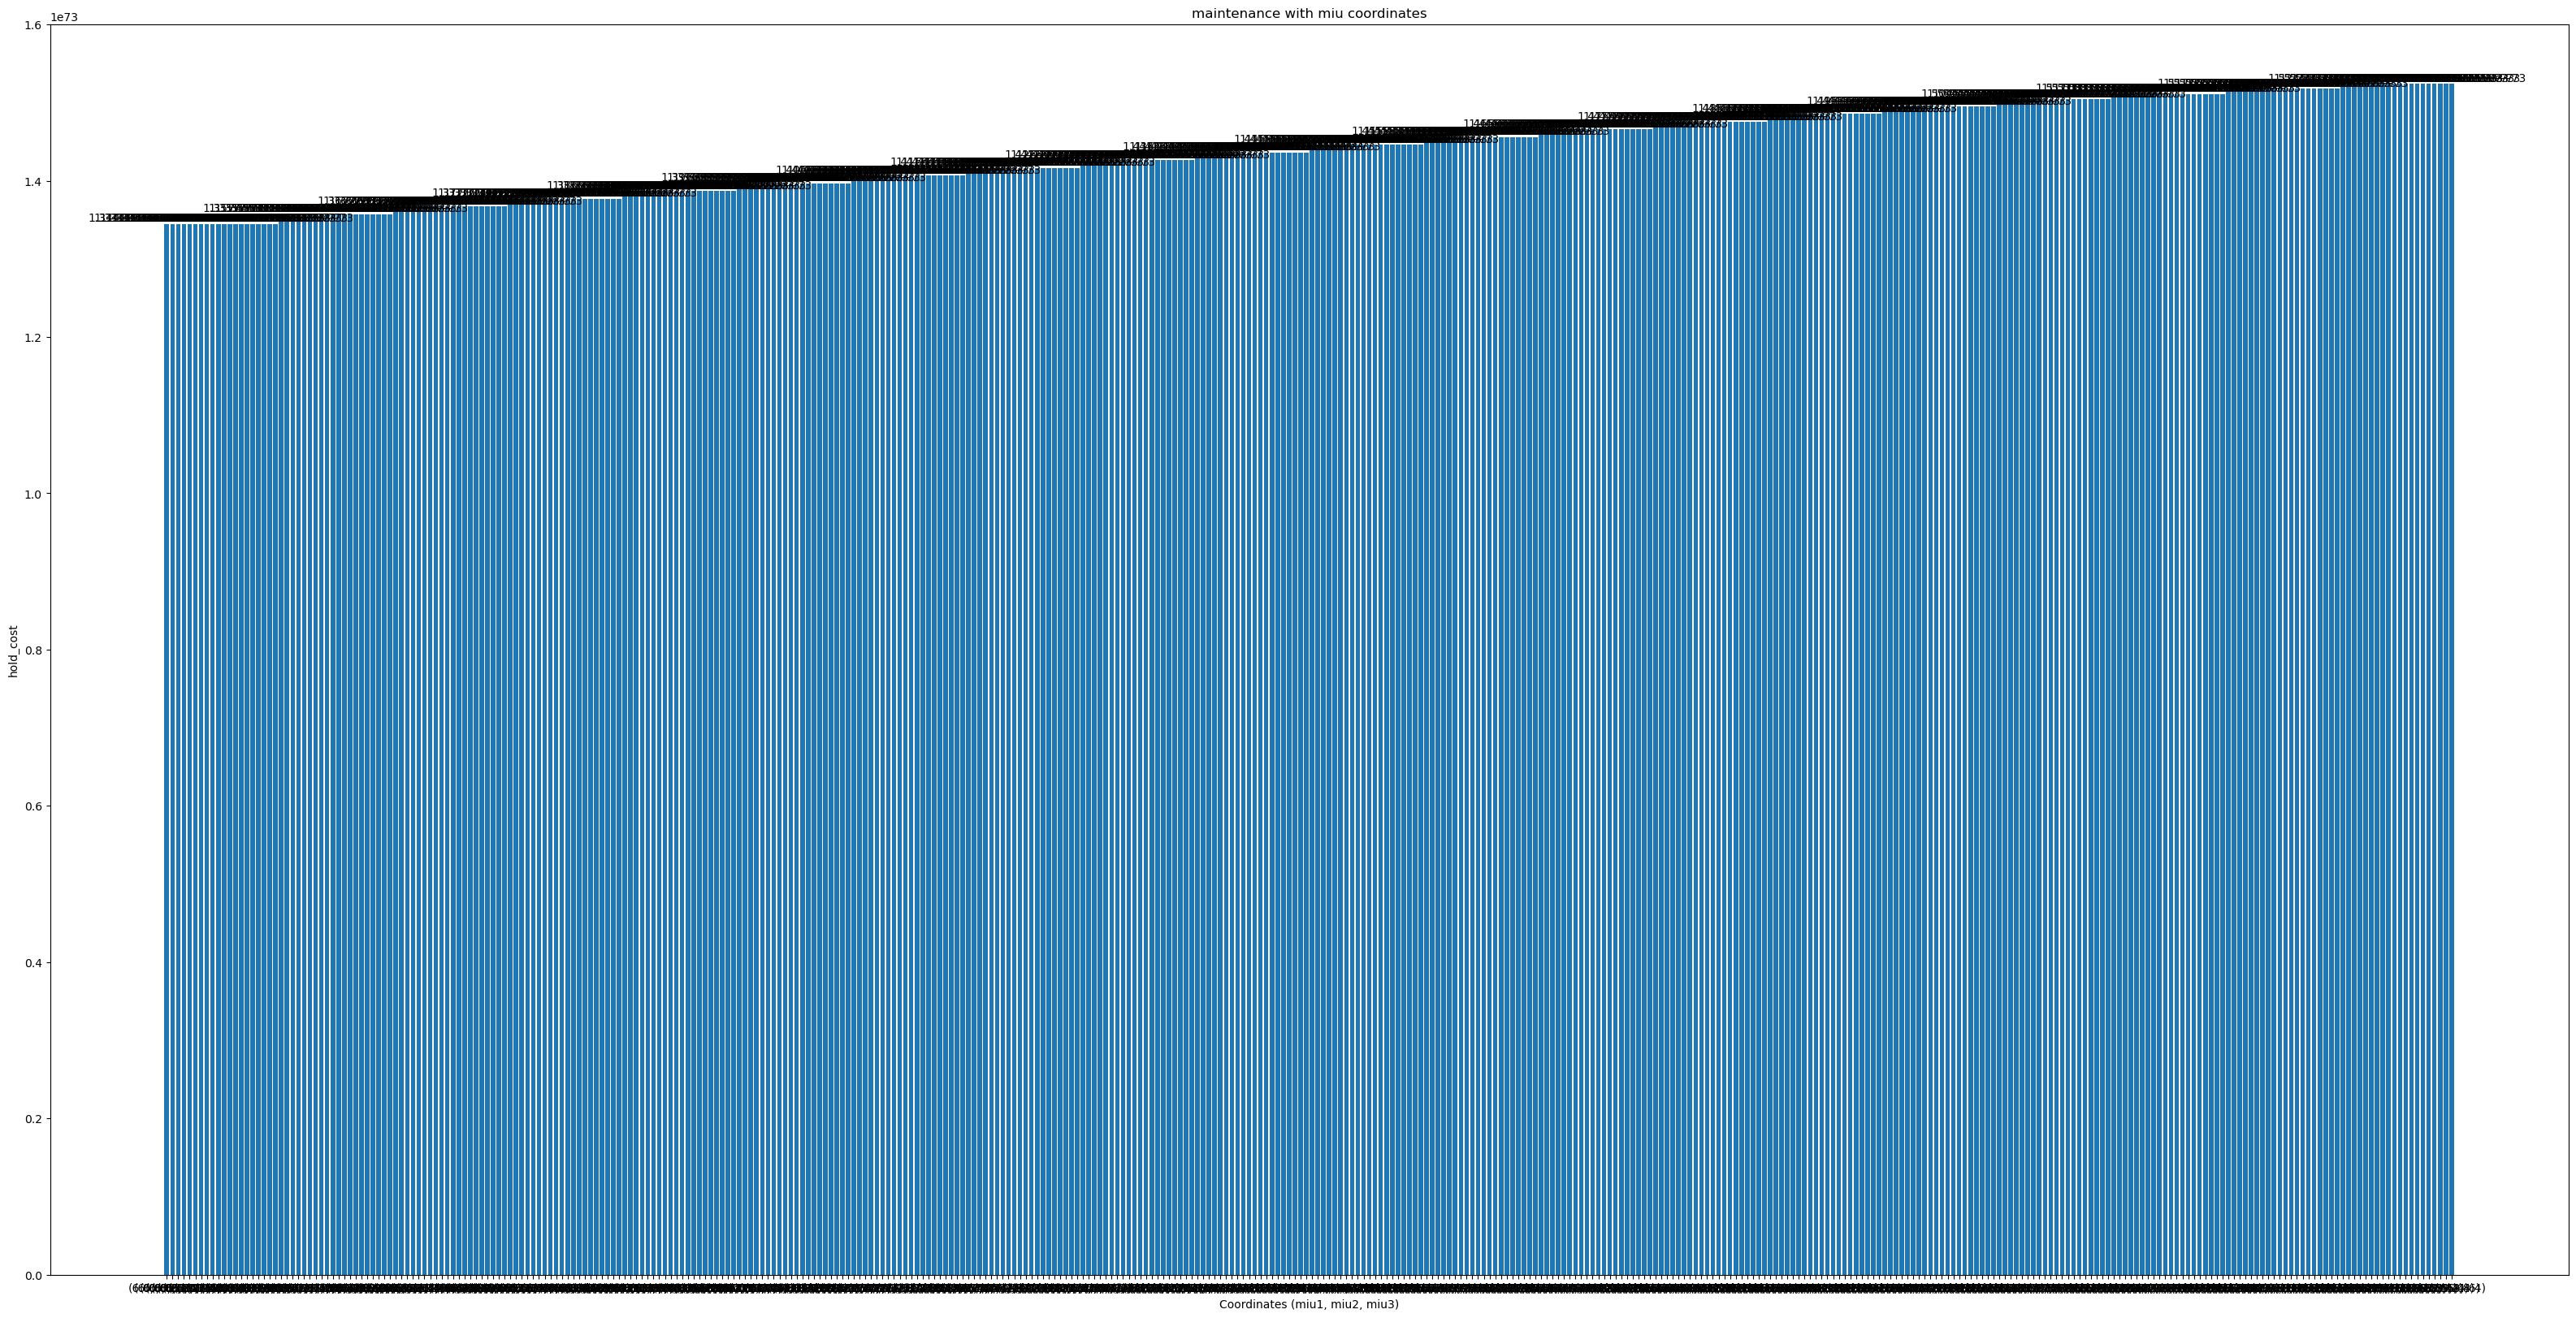

In [42]:
# #log_hold = np.log(hold_cost)
# data = pd.DataFrame({'miu1': [round(miu_1,2) for miu_1 in miu11_final], 'miu2': [round(miu_2,2) for miu_2 in miu22_final], 'miu3': [round(miu_3,2) for miu_3 in miu33], 'hold': hold_cost, 'hold_cost': [round(hold_cost1,0) for hold_cost1 in hold_cost]})
# plt.figure(figsize=(40, 20))
# bars = plt.bar(range(len(data)), data['hold_cost'], tick_label=[f'({i},{j},{k})' for i, j, k in zip(data['miu1'], data['miu2'], data['miu3'])])

# for bar in bars:
#     yval = bar.get_height()
#     plt.text(bar.get_x() + bar.get_width()/2, yval + 0.1, round(yval, 2), ha='center', va='bottom')

# plt.title('maintenance with miu coordinates')
# plt.xlabel('Coordinates (miu1, miu2, miu3)')
# plt.ylabel('hold_cost')

# plt.show()

In [45]:
# xaxis = data[['miu1','miu2','miu3']].values.tolist()
# bar = (
#     Bar()
#     .add_xaxis(xaxis)
#     .add_yaxis("hold_cost", data['hold_cost'].values.tolist())
#     .set_global_opts(title_opts=opts.TitleOpts(title="log(hold_cost) with miu1 and miu2 coordinates"),
#                      xaxis_opts=opts.AxisOpts(type_="category"),
#                      legend_opts=opts.LegendOpts(is_show=True))
# )

# line_data = []
# for i, (x, y, z) in enumerate(zip(data['miu1'], data['miu2'], data['miu3'])):
#     line_data.append((f'({x},{y},{z})', data['hold_cost'][i]))

# line = (
#     Line()
#     .add_xaxis([item[0] for item in line_data])
#     .add_yaxis("hold_cost", [item[1] for item in line_data])
#     .set_series_opts(label_opts=opts.LabelOpts(is_show=False))
# )
# # 
# line.set_global_opts(datazoom_opts=opts.DataZoomOpts(),
#                      xaxis_opts=opts.AxisOpts(type_="category", name="miu1, miu2, miu3"),
#                      yaxis_opts=opts.AxisOpts(name="hold cost"),
#                      legend_opts=opts.LegendOpts(is_show=True),
#                      title_opts=opts.TitleOpts(title="Hold Cost with Different miu"))
# bar.set_global_opts(datazoom_opts=opts.DataZoomOpts())


# line.overlap(bar)

# line.render("hold_cost of 3 suppliers.html")

'/Users/fanwei/Desktop/tud课程/WI4204 advanced modelling/hold_cost of 3 suppliers.html'